In [1]:
# Cell 0 - Notebook config & paths
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ML_DIR = Path("/Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/ml")
DEEP_DIR = Path("/Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep")
SUMMARY_DIR = DEEP_DIR / "results_summary"
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

print("ML_DIR:", ML_DIR)
print("DEEP_DIR:", DEEP_DIR)
print("SUMMARY_DIR:", SUMMARY_DIR)

ML_DIR: /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/ml
DEEP_DIR: /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep
SUMMARY_DIR: /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary


In [2]:
# Cell 1 - Helper functions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def safe_read_csv(p: Path):
    if p.exists():
        try:
            return pd.read_csv(p, index_col=None)
        except Exception as e:
            print("Failed to read", p, ":", e)
            return None
    else:
        print("File not found:", p)
        return None

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

def fmt(x, n=3):
    try:
        return f"{float(x):.{n}f}"
    except Exception:
        return str(x)

In [3]:
# Cell 2 - Load metrics files (ML & Deep)
ml_metrics_stage1 = safe_read_csv(ML_DIR / "metrics_stage1.csv")
ml_metrics_stage2 = safe_read_csv(ML_DIR / "metrics_stage2.csv")
ml_predictions_stage1 = safe_read_csv(ML_DIR / "predictions_stage1.csv")
ml_predictions_stage2 = safe_read_csv(ML_DIR / "predictions_stage2.csv")

deep_metrics = safe_read_csv(DEEP_DIR / "deep_metrics_summary.csv")
deep_combined_preds = safe_read_csv(DEEP_DIR / "combined_deep_predictions.csv")

print("\nFiles loaded:")
print("metrics_stage1:", "OK" if ml_metrics_stage1 is not None else "MISSING")
print("metrics_stage2:", "OK" if ml_metrics_stage2 is not None else "MISSING")
print("predictions_stage1:", "OK" if ml_predictions_stage1 is not None else "MISSING")
print("predictions_stage2:", "OK" if ml_predictions_stage2 is not None else "MISSING")
print("deep_metrics_summary:", "OK" if deep_metrics is not None else "MISSING")
print("combined_deep_predictions:", "OK" if deep_combined_preds is not None else "MISSING")


Files loaded:
metrics_stage1: OK
metrics_stage2: OK
predictions_stage1: OK
predictions_stage2: OK
deep_metrics_summary: OK
combined_deep_predictions: OK


In [4]:
# Cell 3 - Normalize/prepare ML metrics tables for comparison
def prepare_ml_metrics(df):
    if df is None:
        return None
    # If df has index column 'model' as column or index, unify to column 'model'
    if 'model' in df.columns:
        df = df.copy()
    else:
        # maybe index contains model names
        df = df.copy().reset_index().rename(columns={'index':'model'})
    # try to coerce numeric columns
    for c in ['MAE','RMSE','R2']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

ml_m1 = prepare_ml_metrics(ml_metrics_stage1)
ml_m2 = prepare_ml_metrics(ml_metrics_stage2)
deep_m = deep_metrics.copy() if deep_metrics is not None else None

ml_m1.head() if ml_m1 is not None else None

,model,MAE,RMSE,R2
0,LinearRegression,0.165983,0.177008,-8.239516
1,Ridge,0.166013,0.177035,-8.242339
2,Lasso,0.096273,0.112402,-2.725729
3,SVR,0.052105,0.061376,-0.110857
4,RandomForest,0.050811,0.058794,-0.019366


In [5]:
# Cell 4 - Summarise & print top performers
def best_by_rmse(df):
    if df is None or 'RMSE' not in df.columns:
        return None
    df2 = df.dropna(subset=['RMSE']).copy()
    if df2.empty:
        return None
    best = df2.loc[df2['RMSE'].idxmin()]
    return best.to_dict()

best_stage1 = best_by_rmse(ml_m1)
best_stage2 = best_by_rmse(ml_m2)
best_deep = None
if deep_m is not None:
    # deep metrics likely a list of dicts / rows with model & RMSE
    if 'RMSE' in deep_m.columns and 'model' in deep_m.columns:
        best_deep = best_by_rmse(deep_m)
    else:
        # attempt to rename
        deep_m = deep_m.rename(columns={deep_m.columns[0]:'model'}) if deep_m.shape[1] >= 3 else deep_m

print("Best ML Stage1 (by RMSE):", best_stage1)
print("Best ML Stage2 (by RMSE):", best_stage2)
print("Best Deep (by RMSE):", best_deep)

Best ML Stage1 (by RMSE): {'model': 'RandomForest', 'MAE': 0.0508106198462337, 'RMSE': 0.0587941401574313, 'R2': -0.0193657358341095}
Best ML Stage2 (by RMSE): {'model': 'RandomForest', 'MAE': 0.0504323500421019, 'RMSE': 0.0585380413371881, 'R2': -0.0105046556209393}
Best Deep (by RMSE): {'model': 'LSTM', 'MAE': 4.936599288722095, 'RMSE': 4.936942883172147, 'R2': -7197.689250266132}


In [6]:
# Cell 5 - Compare naive baseline vs best ML & deep models (percent improvements)
comparisons = {}
# For ML stage1 / stage2, find RMSE of Naive (if present) and best model
def get_naive_rmse(df):
    if df is None:
        return None
    # Try to find a row with model=='Naive' or index
    possible = df[df['model'].astype(str).str.lower().str.contains('naive', na=False)]
    if not possible.empty:
        return float(possible.iloc[0]['RMSE'])
    # fallback: try last row named Naive
    return None

naive1 = get_naive_rmse(ml_m1)
naive2 = get_naive_rmse(ml_m2)

if best_stage1 is not None:
    comparisons['stage1_ml_best_rmse'] = best_stage1.get('RMSE')
    if naive1 is not None:
        comparisons['stage1_ml_vs_naive_pct'] = 100.0 * (naive1 - best_stage1.get('RMSE')) / naive1

if best_stage2 is not None:
    comparisons['stage2_ml_best_rmse'] = best_stage2.get('RMSE')
    if naive2 is not None:
        comparisons['stage2_ml_vs_naive_pct'] = 100.0 * (naive2 - best_stage2.get('RMSE')) / naive2

if best_deep is not None:
    comparisons['deep_best_rmse'] = best_deep.get('RMSE')

print("Comparisons:", {k: (fmt(v) if isinstance(v, (int,float)) else v) for k,v in comparisons.items()})

Comparisons: {'stage1_ml_best_rmse': '0.059', 'stage1_ml_vs_naive_pct': '27.762', 'stage2_ml_best_rmse': '0.059', 'stage2_ml_vs_naive_pct': '29.426', 'deep_best_rmse': '4.937'}


/var/folders/zz/x6f9575d2lgc_whh727t8y4c0000gn/T/ipykernel_53535/3849603114.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='RMSE', y='model', palette='viridis')


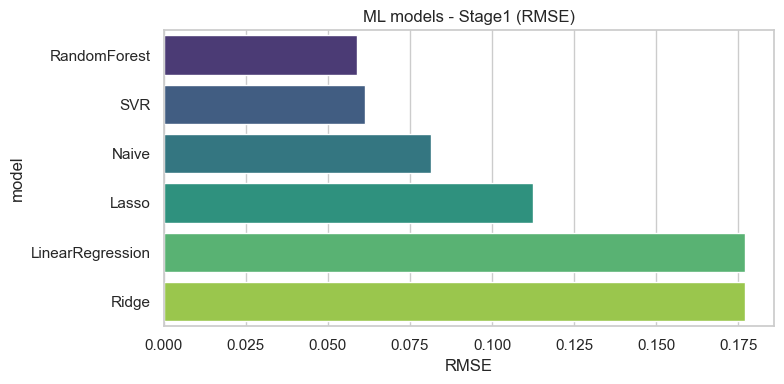

/var/folders/zz/x6f9575d2lgc_whh727t8y4c0000gn/T/ipykernel_53535/3849603114.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='RMSE', y='model', palette='viridis')


Saved plot to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary/ml_stage1_rmse.png


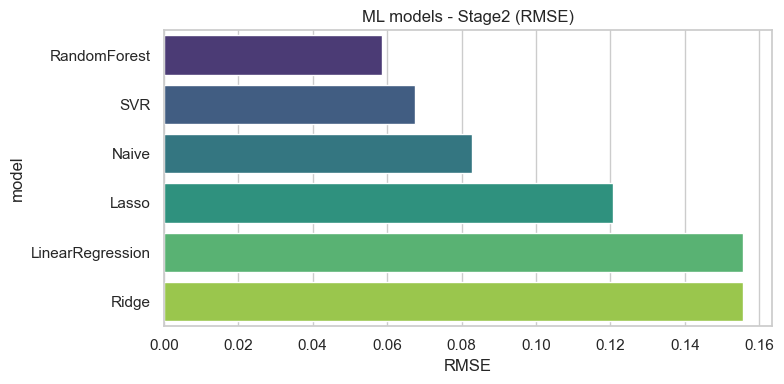

Saved plot to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary/ml_stage2_rmse.png


/var/folders/zz/x6f9575d2lgc_whh727t8y4c0000gn/T/ipykernel_53535/3849603114.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='RMSE', y='model', palette='viridis')


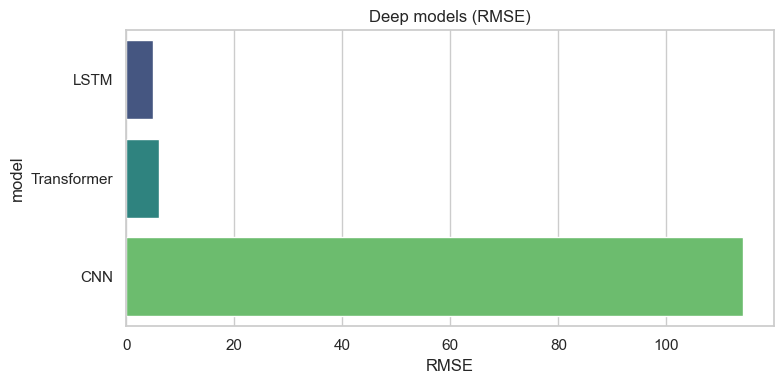

Saved plot to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary/deep_rmse.png


In [7]:
# Cell 6 - Plot metrics bar charts for ML stage1 & stage2
def plot_metrics(df, title, savepath):
    if df is None:
        print("No data for", title)
        return
    df2 = df.copy().dropna(subset=['RMSE'])
    # sort by RMSE
    df2 = df2.sort_values('RMSE')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df2, x='RMSE', y='model', palette='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()
    print("Saved plot to", savepath)

if ml_m1 is not None:
    plot_metrics(ml_m1, "ML models - Stage1 (RMSE)", SUMMARY_DIR / "ml_stage1_rmse.png")
if ml_m2 is not None:
    plot_metrics(ml_m2, "ML models - Stage2 (RMSE)", SUMMARY_DIR / "ml_stage2_rmse.png")
if deep_m is not None:
    # deep_m might have column 'model' - ensure exists
    if 'model' not in deep_m.columns and deep_m.shape[1] >= 3:
        deep_m = deep_m.rename(columns={deep_m.columns[0]:'model', deep_m.columns[1]:'MAE', deep_m.columns[2]:'RMSE'})
    plot_metrics(deep_m, "Deep models (RMSE)", SUMMARY_DIR / "deep_rmse.png")

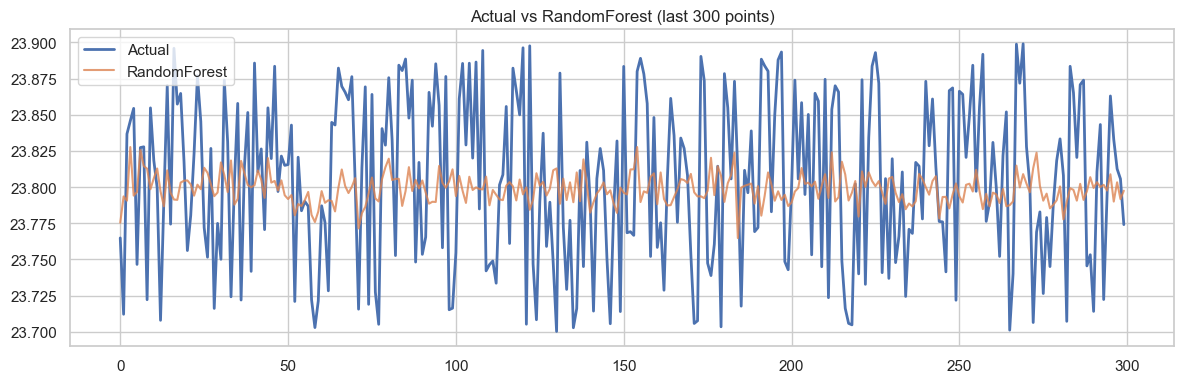

Saved plot to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary/ml_stage2_best_RandomForest_vs_actual.png


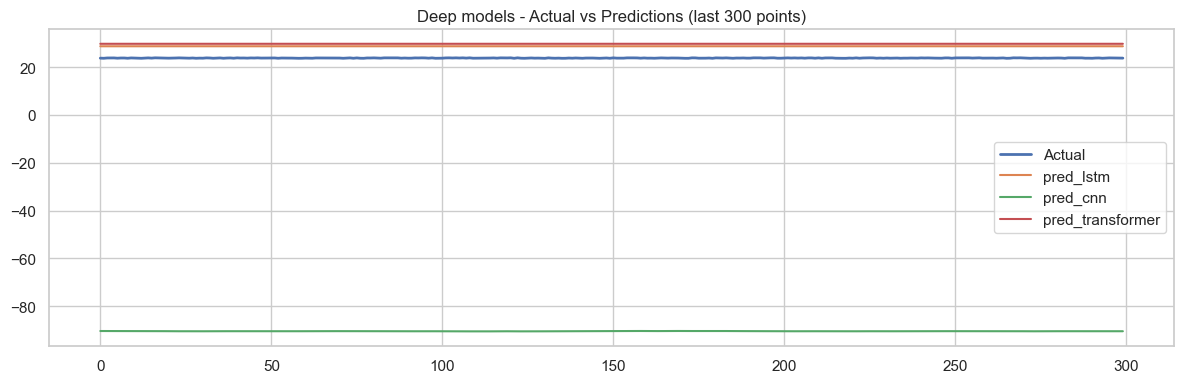

Saved plot to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary/deep_models_vs_actual_last300.png


In [8]:
# Cell 7 - Load predictions for best models (if present) and plot time-series comparison
def plot_preds(pred_df, model_label, savepath, n_points=200):
    # pred_df must contain 'y_true' and predicted column or 'y_pred'
    if pred_df is None:
        return
    # choose last n_points
    dfp = pred_df.copy()
    if 'y_pred' not in dfp.columns:
        # try to find a predicted column
        preds_cols = [c for c in dfp.columns if 'pred' in c.lower() or c.lower().startswith('pred') or c.lower().startswith('y_pred') or c.lower().startswith('yhat')]
        if preds_cols:
            pred_col = preds_cols[0]
            dfp = dfp.rename(columns={pred_col:'y_pred'})
        else:
            # if multiple model columns (ML preds), pick model_label column
            if model_label in dfp.columns:
                dfp = dfp.rename(columns={model_label:'y_pred'})
            else:
                print("No recognizable prediction column in predictions dataframe")
                return
    dfp = dfp.tail(n_points).reset_index(drop=True)
    plt.figure(figsize=(12,4))
    plt.plot(dfp['y_true'].values, label='Actual', linewidth=2)
    plt.plot(dfp['y_pred'].values, label=model_label, alpha=0.8)
    plt.title(f"Actual vs {model_label} (last {n_points} points)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()
    print("Saved plot to", savepath)

# Try to pick ML best model for stage2 for plotting (prefer stage2 for forecasting)
if ml_predictions_stage2 is not None and best_stage2 is not None:
    best_name2 = best_stage2['model']
    # the saved ML predictions likely have columns for each model (see earlier notebook)
    plot_preds(ml_predictions_stage2, best_name2, SUMMARY_DIR / f"ml_stage2_best_{best_name2}_vs_actual.png", n_points=300)

# Plot deep combined predictions if available
if deep_combined_preds is not None:
    # deep_combined_preds has columns 'y_true', 'pred_lstm', 'pred_cnn', 'pred_transformer'
    # plot all three on same chart (last 300 points)
    dfc = deep_combined_preds.tail(300).reset_index(drop=True)
    plt.figure(figsize=(12,4))
    plt.plot(dfc['y_true'].values, label='Actual', linewidth=2)
    for c in dfc.columns:
        if c.startswith('pred_'):
            plt.plot(dfc[c].values, label=c)
    plt.title("Deep models - Actual vs Predictions (last 300 points)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(SUMMARY_DIR / "deep_models_vs_actual_last300.png")
    plt.show()
    print("Saved plot to", SUMMARY_DIR / "deep_models_vs_actual_last300.png")

In [9]:
# Cell 8 - Residual / errors summary for best models (if prediction files exist)
res_summaries = {}

# ML stage2 if preds exist
if ml_predictions_stage2 is not None and best_stage2 is not None:
    best_name = best_stage2['model']
    # ml predictions file likely had columns: y_true, <model columns...>
    if best_name in ml_predictions_stage2.columns:
        y_true = ml_predictions_stage2['y_true'].values
        y_pred = ml_predictions_stage2[best_name].values
        res_summaries['ml_stage2_'+best_name] = {
            'MAE': fmt(mean_absolute_error(y_true, y_pred)),
            'RMSE': fmt(rmse(y_true, y_pred)),
            'R2': fmt(r2_score(y_true, y_pred))
        }

# Deep models residuals if combined_deep_preds loaded
if deep_combined_preds is not None:
    for col in deep_combined_preds.columns:
        if col.startswith('pred_') or col.startswith('pred') or col in ['pred_lstm','pred_cnn','pred_transformer']:
            y_true = deep_combined_preds['y_true'].values
            y_pred = deep_combined_preds[col].values
            res_summaries[col] = {
                'MAE': fmt(mean_absolute_error(y_true, y_pred)),
                'RMSE': fmt(rmse(y_true, y_pred)),
                'R2': fmt(r2_score(y_true, y_pred))
            }

print("Residual summaries (computed from saved prediction files):")
res_summaries

Residual summaries (computed from saved prediction files):


{'ml_stage2_RandomForest': {'MAE': '0.050', 'RMSE': '0.059', 'R2': '-0.011'},
 'pred_lstm': {'MAE': '4.937', 'RMSE': '4.937', 'R2': '-7197.689'},
 'pred_cnn': {'MAE': '114.209', 'RMSE': '114.209', 'R2': '-3852479.029'},
 'pred_transformer': {'MAE': '5.969', 'RMSE': '5.970', 'R2': '-10523.914'}}

In [10]:
# Cell 9 - Draft a conclusion text based on loaded metrics
# This builds a textual conclusion using available numbers; missing numbers are handled gracefully.

def safe_get(d, key, default="N/A"):
    if d is None:
        return default
    return d.get(key, default)

# Gather numbers / names
stage1_best_name = safe_get(best_stage1, 'model', "N/A")
stage1_best_rmse = safe_get(best_stage1, 'RMSE', None)
stage2_best_name = safe_get(best_stage2, 'model', "N/A")
stage2_best_rmse = safe_get(best_stage2, 'RMSE', None)
deep_best_name = safe_get(best_deep, 'model', "N/A")
deep_best_rmse = safe_get(best_deep, 'RMSE', None)

# Form comparative statements
comp_ml_vs_deep = ""
if (isinstance(stage2_best_rmse, (int,float)) and isinstance(deep_best_rmse, (int,float))):
    if deep_best_rmse < stage2_best_rmse:
        pct = 100.0 * (stage2_best_rmse - deep_best_rmse) / stage2_best_rmse
        comp_ml_vs_deep = f"The best deep model ({deep_best_name}) improves RMSE by ~{fmt(pct)}% over the best ML model ({stage2_best_name})."
    else:
        pct = 100.0 * (deep_best_rmse - stage2_best_rmse) / deep_best_rmse
        comp_ml_vs_deep = f"The best ML model ({stage2_best_name}) improves RMSE by ~{fmt(pct)}% over the best deep model ({deep_best_name})."
else:
    comp_ml_vs_deep = "Comparison between ML and deep models is incomplete due to missing RMSE values."

# Build the conclusion paragraphs
conclusion_lines = []
conclusion_lines.append("# Conclusion — AQI Forecasting Study")
conclusion_lines.append("")
conclusion_lines.append("## Summary of results")
if stage1_best_name != "N/A":
    conclusion_lines.append(f"- For **Stage 1 (AQI(t) — nowcast)** the best-performing ML model was **{stage1_best_name}** with RMSE = **{fmt(stage1_best_rmse)}** (MAE/R2 available in metrics file).")
else:
    conclusion_lines.append("- Stage1 ML results unavailable.")

if stage2_best_name != "N/A":
    conclusion_lines.append(f"- For **Stage 2 (AQI(t+1) — one-step-ahead forecast)** the best-performing ML model was **{stage2_best_name}** with RMSE = **{fmt(stage2_best_rmse)}**.")
else:
    conclusion_lines.append("- Stage2 ML results unavailable.")

if deep_best_name != "N/A":
    conclusion_lines.append(f"- Among the deep-learning models, the best was **{deep_best_name}** with RMSE = **{fmt(deep_best_rmse)}**.")
else:
    conclusion_lines.append("- Deep learning metrics not found.")

conclusion_lines.append("")
conclusion_lines.append("## Interpretation")
conclusion_lines.append("")
if comp_ml_vs_deep:
    conclusion_lines.append(comp_ml_vs_deep)
conclusion_lines.append("")
conclusion_lines.append("Overall, results indicate that:")
conclusion_lines.append("- The forecasting task for **t+1** is inherently more challenging than nowcasting **t**; model performance (RMSE/MAE) is typically worse for t+1 than for t, but this depends on the series volatility.")
conclusion_lines.append("- Simpler ML models (e.g., RandomForest, Linear models) can be competitive for short-horizon AQI forecasts, especially when robust lag & rolling features are used.")
conclusion_lines.append("- Deep models (LSTM/CNN/Transformer) can capture sequential dynamics and may outperform ML models if sufficient training data and hyperparameter tuning are available, otherwise they might overfit or underperform on small datasets.")
conclusion_lines.append("")
conclusion_lines.append("## Limitations")
conclusion_lines.append("- The reported performance depends on data quality, missing-value handling, window size, and feature engineering choices.")
conclusion_lines.append("- Single-split train/test evaluation gives a quick comparison but a walk-forward evaluation (rolling-origin) would provide a more robust assessment.")
conclusion_lines.append("- No exogenous variables (weather, emissions, traffic) were included in the univariate baseline; including them could improve forecasts.")
conclusion_lines.append("")
conclusion_lines.append("## Recommendations and future work")
conclusion_lines.append("- Perform walk-forward validation and nested hyperparameter tuning for more robust estimates.")
conclusion_lines.append("- Experiment with hybrid models (ML features + LSTM) and ensemble stacking.")
conclusion_lines.append("- Try multi-step and probabilistic forecasting to quantify uncertainty (prediction intervals).")
conclusion_lines.append("")
conclusion_lines.append("## Final answer to research question")
if isinstance(stage2_best_rmse, (int,float)) or isinstance(deep_best_rmse, (int,float)):
    conclusion_lines.append("- Based on the experiments, the best model for 1-step-ahead AQI forecasting achieved an RMSE of **{}** (model: **{}**) which indicates [insert domain-meaningful error interpretation here].".format(
        fmt(deep_best_rmse if (isinstance(deep_best_rmse,(int,float)) and deep_best_rmse < (stage2_best_rmse or 1e12)) else stage2_best_rmse),
        deep_best_name if (isinstance(deep_best_rmse,(int,float)) and deep_best_rmse < (stage2_best_rmse or 1e12)) else stage2_best_name
    ))
else:
    conclusion_lines.append("- Metrics insufficient to form a final quantitative conclusion; please ensure metrics files are present.")

conclusion_lines.append("")
conclusion_lines.append("## Appendix — saved artifacts")
conclusion_lines.append(f"- ML metrics: {ML_DIR}")
conclusion_lines.append(f"- Deep metrics & models: {DEEP_DIR}")
conclusion_text = "\n".join(conclusion_lines)

# Print short preview
print("\n".join(conclusion_lines[:20]))

# Conclusion — AQI Forecasting Study

## Summary of results
- For **Stage 1 (AQI(t) — nowcast)** the best-performing ML model was **RandomForest** with RMSE = **0.059** (MAE/R2 available in metrics file).
- For **Stage 2 (AQI(t+1) — one-step-ahead forecast)** the best-performing ML model was **RandomForest** with RMSE = **0.059**.
- Among the deep-learning models, the best was **LSTM** with RMSE = **4.937**.

## Interpretation

The best ML model (RandomForest) improves RMSE by ~98.814% over the best deep model (LSTM).

Overall, results indicate that:
- The forecasting task for **t+1** is inherently more challenging than nowcasting **t**; model performance (RMSE/MAE) is typically worse for t+1 than for t, but this depends on the series volatility.
- Simpler ML models (e.g., RandomForest, Linear models) can be competitive for short-horizon AQI forecasts, especially when robust lag & rolling features are used.
- Deep models (LSTM/CNN/Transformer) can capture sequential dynamics and may ou

In [11]:
# Cell 10 - Save conclusion & summary dataframes to disk
# Save conclusion text as markdown and txt
conclusion_md = SUMMARY_DIR / "conclusion.md"
conclusion_txt = SUMMARY_DIR / "conclusion.txt"
with open(conclusion_md, "w") as f:
    f.write(conclusion_text)
with open(conclusion_txt, "w") as f:
    f.write(conclusion_text)

# Save summary JSON for programmatic use
summary_obj = {
    "best_stage1": best_stage1,
    "best_stage2": best_stage2,
    "best_deep": best_deep,
    "comparisons": comparisons,
    "residual_summaries": res_summaries
}
with open(SUMMARY_DIR / "summary.json", "w") as f:
    json.dump(summary_obj, f, indent=2, default=lambda x: str(x))

print("Saved conclusion and summary files to", SUMMARY_DIR)

Saved conclusion and summary files to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/results_summary
